In [1]:
import pandas as pd
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [4]:
from src.lime_timeseries_optimized import *
from keras.engine.saving import load_model
import time
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [5]:
# select a set of background examples to take an expectation over
training_set = np.load('/home/justyna/WORKSPACE/heartbeat_classification/data/processed/preprocessed/physionet/serialized/no_feature_extraction/train.npy')
x_test = np.load('/home/justyna/WORKSPACE/heartbeat_classification/data/processed/preprocessed/physionet/serialized/no_feature_extraction/test.npy')
MODEL = load_model('/home/justyna/WORKSPACE/heartbeat_classification/src/flask-app/convo_weights.h5')
training_labels = np.load('/home/justyna/WORKSPACE/heartbeat_classification/data/processed/preprocessed/physionet/serialized/no_feature_extraction/train_labels.npy')

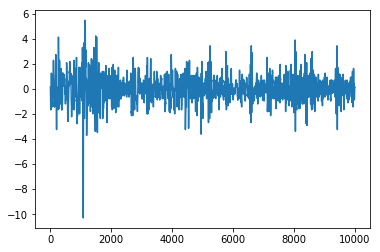

In [6]:
instance = training_set[0]
label = training_labels[0]
plt.plot(instance)

In [7]:
def predict(instances):
    labels = []
    for instance in instances:
        instance = np.reshape(instance, newshape=(1, instance.shape[0], 1))
        labels.append(MODEL.predict(instance))
    return np.array(labels).reshape(len(instances), 2)

In [8]:
def explain():
    now = time.time()
    explanations = explainer.explain_instance(timeseries=instance, training_set=training_set, num_samples=10,num_slices=24, classifier_fn=predict)
    end = time.time()
    execution_time = end - now
    return explanations, execution_time

In [9]:
explainer = LimeTimeSeriesExplanation(feature_selection='auto')

In [10]:
explanations, execution_time = explain()

Explaining


/home/justyna/virtualenvs/heartbeat_env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.310523e-73
  overwrite_a=False)


In [11]:
execution_time

0.4996633529663086

In [12]:
explanations

[(0.7635636329650852,
  [(5, 5.213097340771546e-16),
   (8, 5.213097340771476e-16),
   (3, 1.8213201556091128e-25),
   (7, 1.8213201556091128e-25),
   (1, 1.8212507923940697e-25),
   (4, 6.936323491098249e-30),
   (6, 6.936323491098249e-30),
   (9, 1.9867901966198284e-36),
   (2, 1.986790157190117e-36),
   (0, 7.426170926118064e-44)],
  1.0247358517290195e-13,
  array([0.76356363, 0.76356363, 0.76356363, 0.76356363, 0.76356363,
         0.76356363, 0.76356363, 0.76356363, 0.76356363, 0.76356363])),
 (0.23643632233143114,
  [(5, -5.213099227879267e-16),
   (8, -5.213099227879198e-16),
   (3, -1.8219572536729427e-25),
   (7, -1.8219572536729427e-25),
   (1, -1.8218878903862036e-25),
   (4, -6.936330660691635e-30),
   (6, -6.936330660691635e-30),
   (9, -1.9867910034513032e-36),
   (2, -1.9867909640215613e-36),
   (0, -7.426183032373742e-44)],
  1.0125233984581428e-13,
  array([0.23643632, 0.23643632, 0.23643632, 0.23643632, 0.23643632,
         0.23643632, 0.23643632, 0.23643632, 0.23643

5 5.213097340771546e-16
8 5.213097340771476e-16
3 1.8213201556091128e-25
7 1.8213201556091128e-25
1 1.8212507923940697e-25
4 6.936323491098249e-30
6 6.936323491098249e-30
9 1.9867901966198284e-36
2 1.986790157190117e-36
0 7.426170926118064e-44


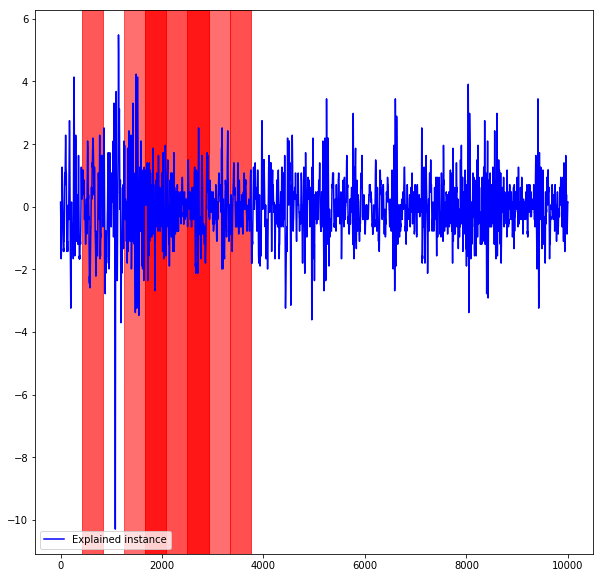

In [16]:
values_per_slice = math.ceil(len(instance) / 24)
plt.figure(figsize=(10,10))
plt.plot(instance, color='b', label='Explained instance')
# plt.plot(coffee_test_x.iloc[15:,:].mean(), color='green', label='Mean of other class')
plt.legend(loc='lower left')
exp = explanations[0][1]
for i in range(10):
    feature, weight = exp[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    print(feature, weight)
    plt.axvspan(start , end, color='red', alpha=(weight*(10**30)))

-5.213099227879267e-16
-5.213099227879198e-16
-1.8219572536729427e-25
-1.8219572536729427e-25
-1.8218878903862036e-25
-6.936330660691635e-30
-6.936330660691635e-30
-1.9867910034513032e-36
-1.9867909640215613e-36
-7.426183032373742e-44


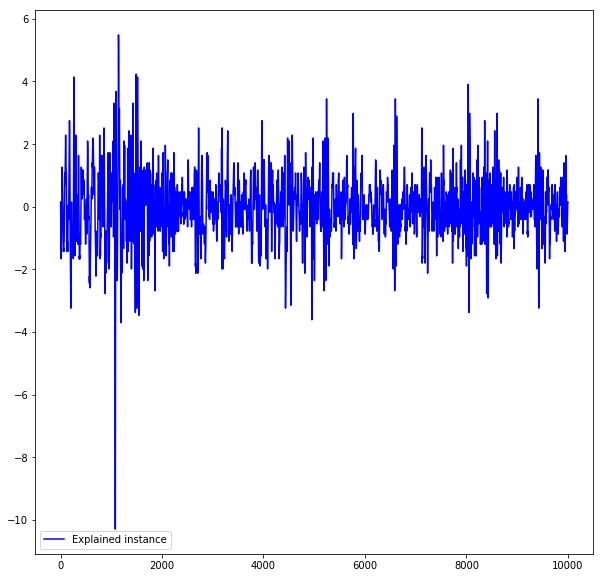

In [14]:
values_per_slice = math.ceil(len(instance) / 24)
plt.figure(figsize=(10,10))
plt.plot(instance, color='b', label='Explained instance')
# plt.plot(coffee_test_x.iloc[15:,:].mean(), color='green', label='Mean of other class')
plt.legend(loc='lower left')
exp = explanations[1][1]
for i in range(10):
    feature, weight = exp[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    print(weight)
    plt.axvspan(start , end, color='red', alpha=(weight*(10**10)))

In [15]:
a = np.array([[1,1,1],[0,0,0],[1,2,3]])
np.mean(a)

1.0